<a href="https://colab.research.google.com/github/Daviramos7/analise-despesas-recife-pyspark/blob/main/analise_despesas_recife.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total Liquidado: R$ 7,803,361,234.91
Média: R$ 61,386.27
Total Saúde: R$ 1,668,250,043.27

--- TOP 10 ÓRGÃOS ---


,orgao_nome,Gasto (R$)
Ranking,,
1,SECRETARIA DE SAÚDE - ADMINISTRAÇÃO SUPERVISIO...,"R$ 1.668.250.043,27"
2,SECRETARIA DE EDUCAÇÃO,"R$ 1.564.218.920,32"
3,SECRETARIA DE INFRAESTRUTURA - ADMINISTRAÇÃO S...,"R$ 1.274.893.472,20"
4,"SECRETARIA DE PLANEJAMENTO, GESTÃO E TRANSFORM...","R$ 928.018.667,95"
5,ENCARGOS GERAIS DO MUNICÍPIO,"R$ 806.929.638,80"
6,SECRETARIA DE CULTURA - ADMINISTRAÇÃO SUPERVIS...,"R$ 182.724.953,07"
7,"SECRETARIA DE PLANEJAMENTO, GESTÃO E TRANSFORM...","R$ 155.942.360,50"
8,SECRETARIA DE POLÍTICA URBANA E LICENCIAMENTO,"R$ 147.815.908,21"
9,SECRETARIA DE POLÍTICA URBANA E LICENCIAMENTO ...,"R$ 127.568.377,17"


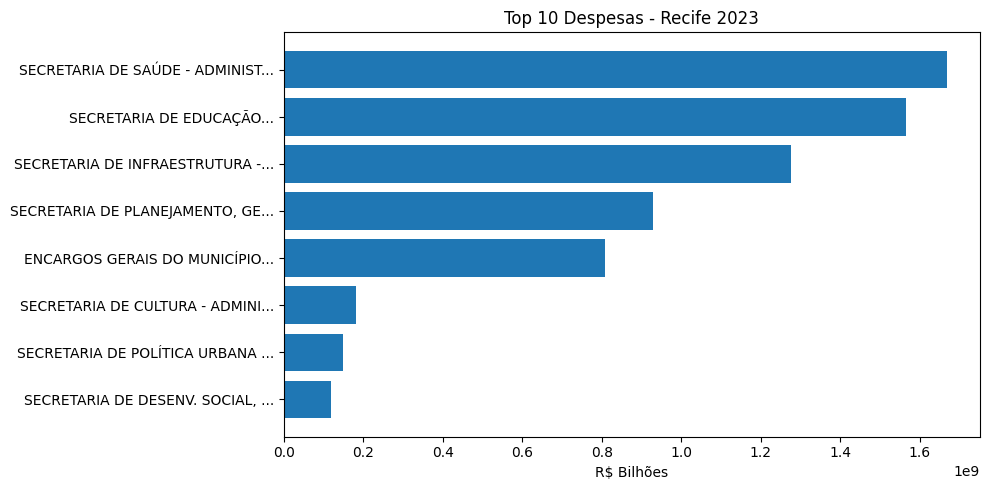

--------------------------------------------------

### Relatório Resumido: Análise de Despesas Públicas (2023)

**1. Resultados**
A análise demonstra foco em serviços essenciais.
* **Maiores Despesas:** Saúde (R\$ 1,668,250,043.27) e Educação lideram o orçamento.
* **Total Liquidado:** R\$ 7,803,361,234.91.

**2. Interpretação**
Os dados refletem o cumprimento das obrigações constitucionais e o alto custo operacional do SUS e da rede de ensino municipal.

**3. Metodologia e Soluções**
* **Tratamento:** Valores em formato brasileiro foram convertidos via Regex (PySpark) para `DoubleType`.
* **Encoding:** Leitura em UTF-8 utilizada para corrigir acentuação.

--------------------------------------------------


In [2]:
# --- 1. CONFIGURAÇÃO E DADOS ---
!pip install pyspark -q

import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, desc, regexp_replace
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

spark = SparkSession.builder.master("local[*]").appName("AnaliseRecife").getOrCreate()

# Download silencioso
url = "http://dados.recife.pe.gov.br/dataset/4e008cec-c6a8-40cf-8fc7-d1530168b816/resource/ea074e10-46a1-46a4-a2a4-47d1b331544d/download/despesasorcamentarias2023.csv"
arq = "despesas2023.csv"
if not os.path.exists(arq):
    os.system(f"wget -O {arq} {url}")

# Leitura e Tratamento
df = spark.read.csv(arq, header=True, sep=";", inferSchema=True, encoding="utf-8")
df = df.withColumn("v_clean", regexp_replace(col("valor_liquidado"), r"\.", "")) \
       .withColumn("v_clean", regexp_replace(col("v_clean"), ",", ".")) \
       .withColumn("valor", col("v_clean").cast(DoubleType()))

# --- 2. CÁLCULOS ---
total = df.agg(sum("valor")).collect()[0][0]
media = df.agg(avg("valor")).collect()[0][0]

# Filtro Saúde
saude = df.filter(col("orgao_nome").contains("SAÚDE") | col("orgao_nome").contains("SAUDE")) \
          .agg(sum("valor")).collect()[0][0] or 0.0

# Top 10 Ranking
top10 = df.groupBy("orgao_nome").agg(sum("valor").alias("total")).orderBy(desc("total")).limit(10)
pdf = top10.toPandas()

# --- 3. SAÍDAS (TABELA E GRÁFICO) ---
# Formatação Tabela
pdf["Gasto (R$)"] = pdf["total"].apply(lambda x: f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
pdf.index = pdf.index + 1
pdf.index.name = "Ranking"

print(f"Total Liquidado: R$ {total:,.2f}")
print(f"Média: R$ {media:,.2f}")
print(f"Total Saúde: R$ {saude:,.2f}")
print("\n--- TOP 10 ÓRGÃOS ---")
display(pdf[["orgao_nome", "Gasto (R$)"]])

# Gráfico
plt.figure(figsize=(10, 5))
plt.barh(pdf['orgao_nome'].apply(lambda x: x[:30]+'...'), pdf['total'], color='#1f77b4')
plt.xlabel('R$ Bilhões')
plt.title('Top 10 Despesas - Recife 2023')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- 4. RELATÓRIO FINAL ---
# O 'rf' abaixo evita o SyntaxWarning e mantém a barra pro Markdown não quebrar
print("-" * 50)
print(rf"""
### Relatório Resumido: Análise de Despesas Públicas (2023)

**1. Resultados**
A análise demonstra foco em serviços essenciais.
* **Maiores Despesas:** Saúde (R\$ {saude:,.2f}) e Educação lideram o orçamento.
* **Total Liquidado:** R\$ {total:,.2f}.

**2. Interpretação**
Os dados refletem o cumprimento das obrigações constitucionais e o alto custo operacional do SUS e da rede de ensino municipal.

**3. Metodologia e Soluções**
* **Tratamento:** Valores em formato brasileiro foram convertidos via Regex (PySpark) para `DoubleType`.
* **Encoding:** Leitura em UTF-8 utilizada para corrigir acentuação.
""")
print("-" * 50)

### Relatório Resumido: Análise de Despesas Públicas do Recife (2023)

**1. Resumo dos Resultados**
A análise processou a base de dados de despesas orçamentárias de 2023. Os dados indicam que o maior volume financeiro da prefeitura é destinado diretamente aos serviços essenciais.
* **Maior Despesa:** O setor de **Saúde** lidera os gastos liquidados com aproximadamente **R\$ 1,66 bilhão**, seguido de perto pela **Educação** (R\$ 1,56 bilhão) e Infraestrutura.
* **Total:** O total liquidado no ano ultrapassa a marca de R\$ 7,8 bilhões.

**2. Interpretação dos Dados**
Os números indicam uma gestão pública focada na manutenção do SUS e da rede municipal de ensino. A alta despesa nessas áreas é consistente com as obrigações constitucionais do município. A presença de "Encargos Gerais" no Top 5 sugere também um alto custo operacional fixo da máquina pública.

**3. Dificuldades Encontradas e Soluções**
Durante o processamento no PySpark, a principal dificuldade foi a **formatação da moeda brasileira** (ex: `1.000,00`), que o sistema lia como texto.
* *Solução:* Foi utilizada a função `regexp_replace` para remover pontos e substituir a vírgula decimal, permitindo a conversão correta para cálculo numérico (`DoubleType`).
* *Encoding:* Foi necessário forçar a leitura do arquivo em `UTF-8` para corrigir erros de acentuação nos nomes dos órgãos.

**4. Insights**
A análise visual (gráfico de barras) evidenciou uma grande disparidade entre as "super secretarias" (Saúde, Educação, Infraestrutura) e as demais pastas, mostrando que o orçamento é altamente concentrado nas áreas finalísticas.